In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

In [2]:
jtplot.style()
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
import tensorflow as tf
import numpy as np
from database.MIMIC_cache_exp import MIMIC_cache_discretized_exp
from utils.plotting import plot_scatter_simple, plot_hist_simple, plot_line, plot_box_simple
from policy_training_and_evaluation.run_dqn import reward_func

In [4]:
feature_names = ["Albumin", "Bicarbonate", "Bilirubin", "Blood urea nitrogen", "CO2",
                  "Calcium", "Calcium ionized", "Capillary refill rate", "Chloride", "Cholesterol",
                  "Creatinine", "Diastolic blood pressure", "Fraction inspired oxygen", "Glascow coma scale total", "Glucose",
                  "Heart Rate", "Hemoglobin", "Lactate", "Magnesium", "Mean blood pressure",
                  "Oxygen saturation", "Partial pressure of carbon dioxide", "Partial pressure of oxygen", "Partial thromboplastin time",
                  "Platelets", "Potassium", "Prothrombin time", "Respiratory rate", "Systolic blood pressure",
                  "Temperature", "Urine output", "Weight", "White blood cell count", "pH"]
feature_names += ['Null']
idx_to_feature_name = {i: name for i, name in enumerate(feature_names)}
idx_to_feature_name

{0: 'Albumin',
 1: 'Bicarbonate',
 2: 'Bilirubin',
 3: 'Blood urea nitrogen',
 4: 'CO2',
 5: 'Calcium',
 6: 'Calcium ionized',
 7: 'Capillary refill rate',
 8: 'Chloride',
 9: 'Cholesterol',
 10: 'Creatinine',
 11: 'Diastolic blood pressure',
 12: 'Fraction inspired oxygen',
 13: 'Glascow coma scale total',
 14: 'Glucose',
 15: 'Heart Rate',
 16: 'Hemoglobin',
 17: 'Lactate',
 18: 'Magnesium',
 19: 'Mean blood pressure',
 20: 'Oxygen saturation',
 21: 'Partial pressure of carbon dioxide',
 22: 'Partial pressure of oxygen',
 23: 'Partial thromboplastin time',
 24: 'Platelets',
 25: 'Potassium',
 26: 'Prothrombin time',
 27: 'Respiratory rate',
 28: 'Systolic blood pressure',
 29: 'Temperature',
 30: 'Urine output',
 31: 'Weight',
 32: 'White blood cell count',
 33: 'pH',
 34: 'Null'}

# Analysis distribution of rewards for designing reward function

In [5]:
exp_dir = {7.5: '../RL_exp_cache/0516-7_5mins-48hrs-joint-exp/',
          15: '../RL_exp_cache/0516-15mins-48hrs-joint-exp/',
          30: '../RL_exp_cache/0516-30mins-48hrs/',
          60: '../RL_exp_cache/0516-60mins-48hrs/'}

In [6]:
sess = tf.Session()
mimic_exp_loader = {k: MIMIC_cache_discretized_exp(cache_dir=exp_dir[k]).gen_train_experience(sess, batch_size=100000) for k in exp_dir}

In [7]:
exp = {k: next(mimic_exp_loader[k]) for k in mimic_exp_loader}

In [9]:
exp[7.5].keys()

dict_keys(['cur_state', 'next_state', 'cur_probs', 'next_probs', 'cur_actions', 'next_actions', 'labels', 'patient_ind', 'the_step', 'total_steps'])

In [10]:
a = {k: exp[k]['cur_actions'] for k in exp}

In [11]:
null_actions_only = {k: (np.sum(a[k], axis=1) == 1).tolist() for k in a}
real_actions_only = {k: (np.sum(a[k], axis=1) != 1).tolist() for k in a}

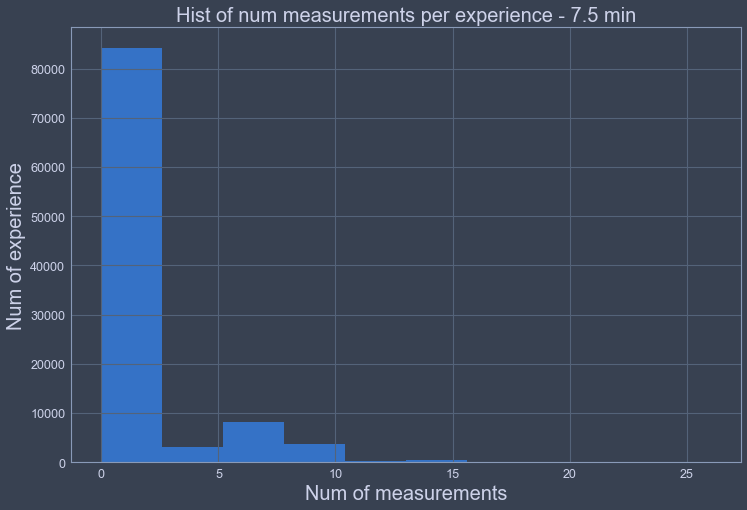

Num experience with real measurements: 18062,
Num wiout: 81938


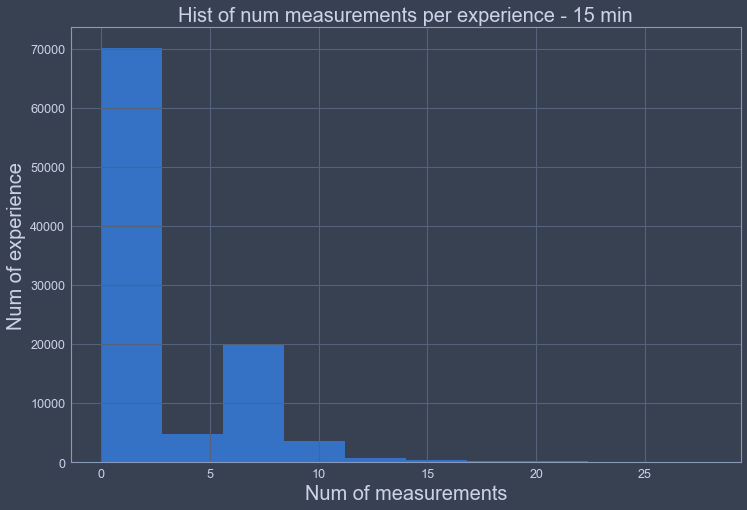

Num experience with real measurements: 33553,
Num wiout: 66447


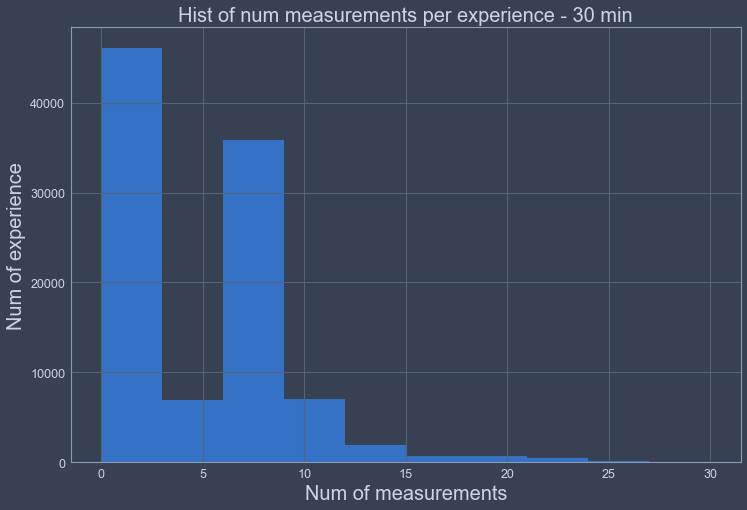

Num experience with real measurements: 58951,
Num wiout: 41049


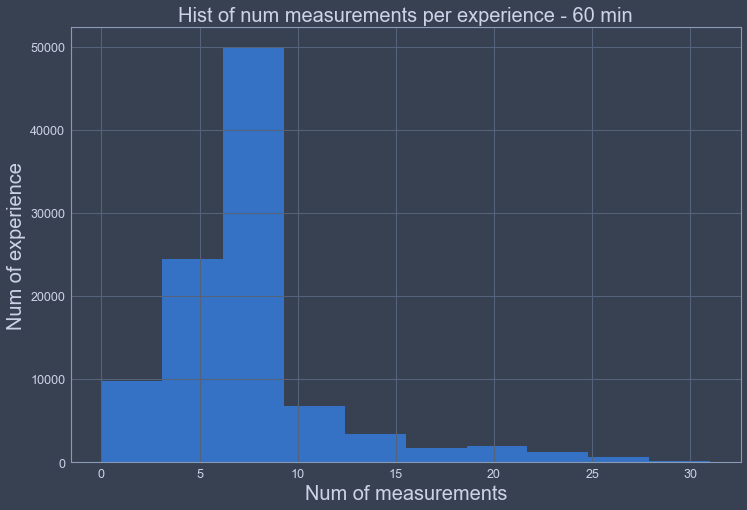

Num experience with real measurements: 96107,
Num wiout: 3893


In [12]:
for k in null_actions_only:
    plot_hist_simple(np.sum(a[k][:,:-1], axis=1),
                     title='Hist of num measurements per experience - {} min'.format(k),
                    xlabel='Num of measurements',
                    ylabel='Num of experience')
    print('Num experience with real measurements: {},\nNum wiout: {}'.format(sum(real_actions_only[k]), sum(null_actions_only[k])))

In [75]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.0   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions']).tolist() for k in exp}


## Analysis which actions correlated with extreme reward

In [76]:
len(a[7.5])

100000

In [77]:
high_reward_actions = {k: np.sum(np.concatenate([a[k][i][None, :] 
                                          for i in range(len(r[k])) if r[k][i] > 5]),
                                axis=0)
                       for k in a}

In [78]:
{idx_to_feature_name[k]: high_reward_actions[15][k] for k in idx_to_feature_name}

{'Albumin': 19.0,
 'Bicarbonate': 93.0,
 'Bilirubin': 31.0,
 'Blood urea nitrogen': 92.0,
 'CO2': 38.0,
 'Calcium': 83.0,
 'Calcium ionized': 18.0,
 'Capillary refill rate': 3.0,
 'Chloride': 93.0,
 'Cholesterol': 0.0,
 'Creatinine': 97.0,
 'Diastolic blood pressure': 561.0,
 'Fraction inspired oxygen': 29.0,
 'Glascow coma scale total': 147.0,
 'Glucose': 172.0,
 'Heart Rate': 568.0,
 'Hemoglobin': 86.0,
 'Lactate': 17.0,
 'Magnesium': 92.0,
 'Mean blood pressure': 553.0,
 'Oxygen saturation': 363.0,
 'Partial pressure of carbon dioxide': 38.0,
 'Partial pressure of oxygen': 24.0,
 'Partial thromboplastin time': 67.0,
 'Platelets': 87.0,
 'Potassium': 101.0,
 'Prothrombin time': 64.0,
 'Respiratory rate': 545.0,
 'Systolic blood pressure': 561.0,
 'Temperature': 232.0,
 'Urine output': 234.0,
 'Weight': 11.0,
 'White blood cell count': 81.0,
 'pH': 47.0,
 'Null': 935.0}

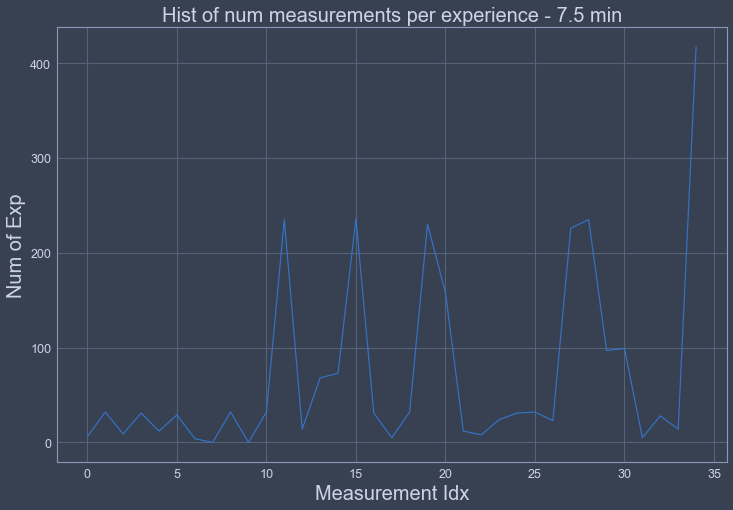

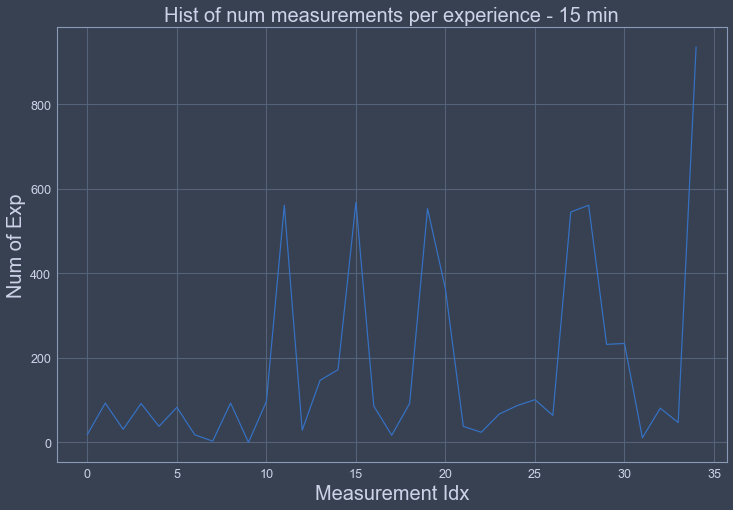

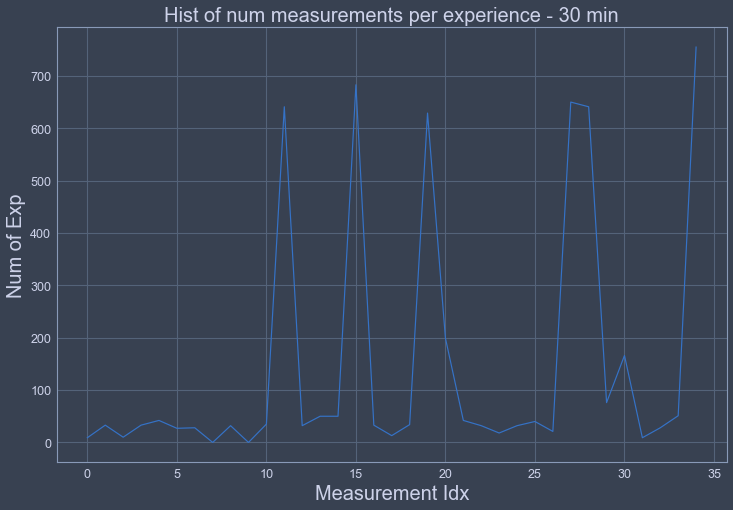

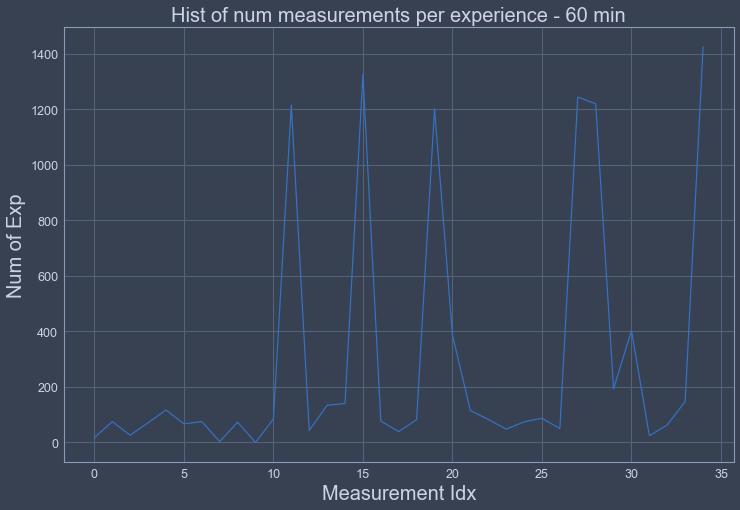

In [79]:
for k in high_reward_actions:
    plot_line(range(35),
              high_reward_actions[k],
                     title='Hist of num measurements per experience - {} min'.format(k),
                    xlabel='Measurement Idx',
                    ylabel='Num of Exp')

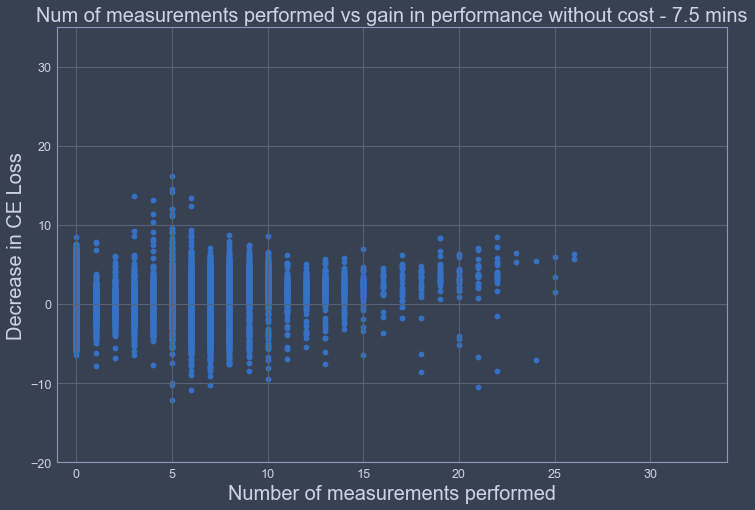

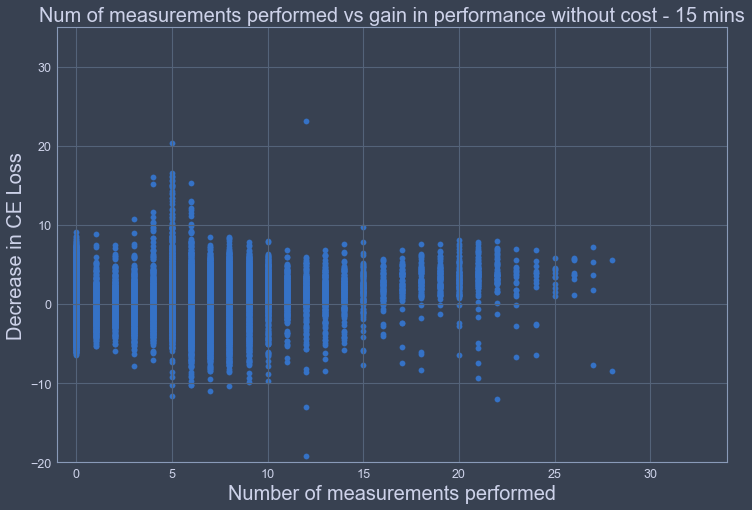

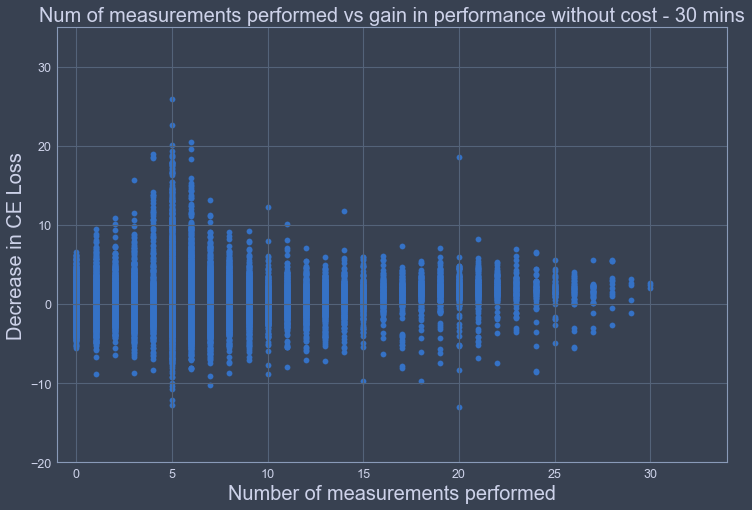

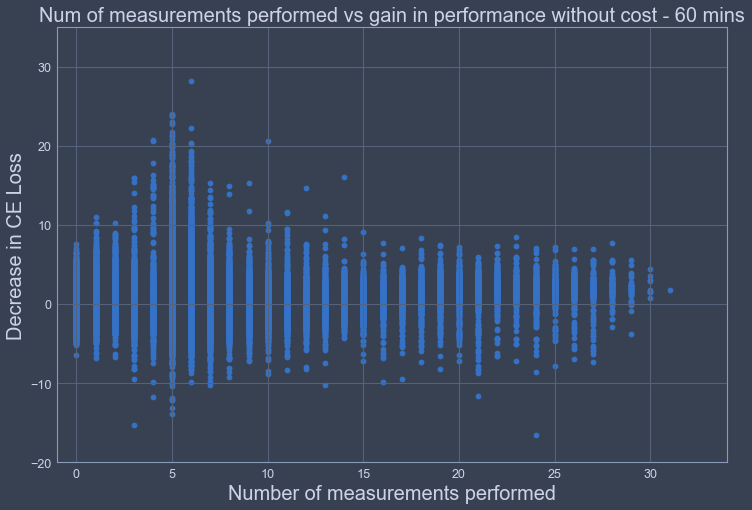

In [52]:
for k in a:
    plot_scatter_simple(np.sum(a[k][:,:-1], axis=1), r[k],
                        title='Num of measurements performed vs gain in performance without cost - {} mins'.format(k),
                        ylabel='Decrease in CE Loss',
                        xlabel='Number of measurements performed',
                       xlim=(-1, 34),
                       ylim=(-20,35))

In [26]:
from utils.math import cross_entropy_loss
import numpy as np

In [34]:
print((cross_entropy_loss(1, 0.5) - cross_entropy_loss(1, 0.55)) * 100)
print((cross_entropy_loss(labels=1, probs=0.47) - cross_entropy_loss(1, 0.52)) * 100)
print((cross_entropy_loss(1, 0.7) - cross_entropy_loss(1, 0.715)) * 100) 

9.531017980432487
10.109611687136887
2.120220765060299


## check out different measurement costs

In [41]:
import pickle

In [42]:
per_action_cost = {k: pickle.load(open(exp_dir[k] + 'per_action_cost.pkl', 'rb')) for k in exp_dir}

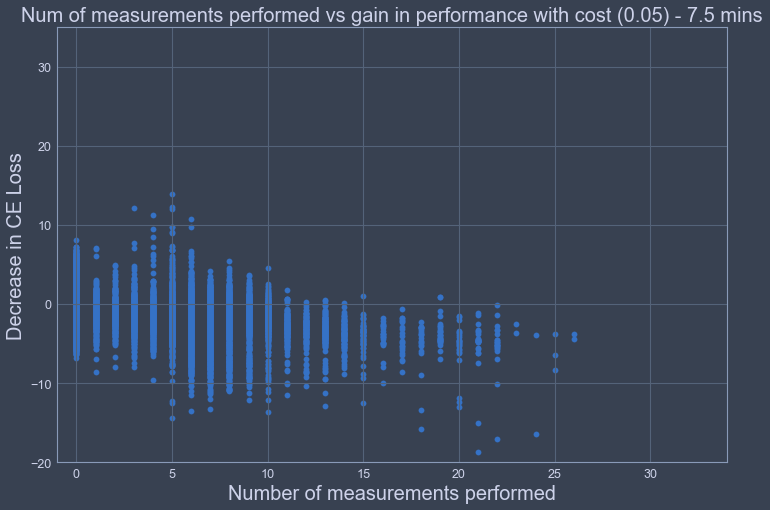

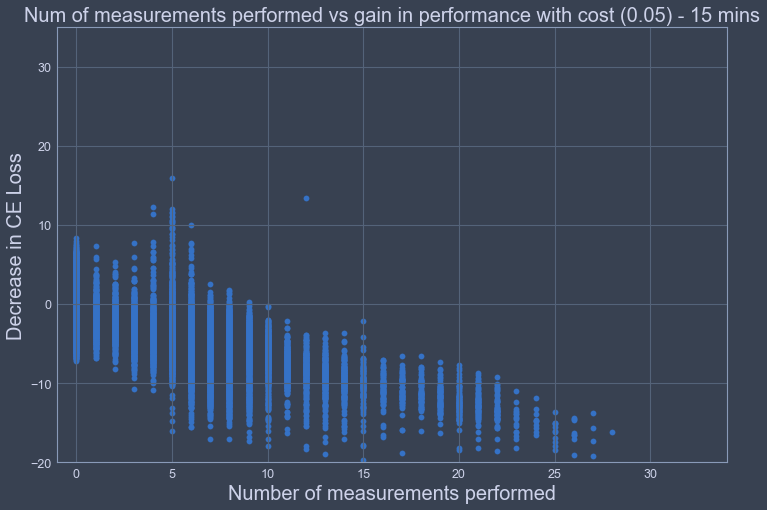

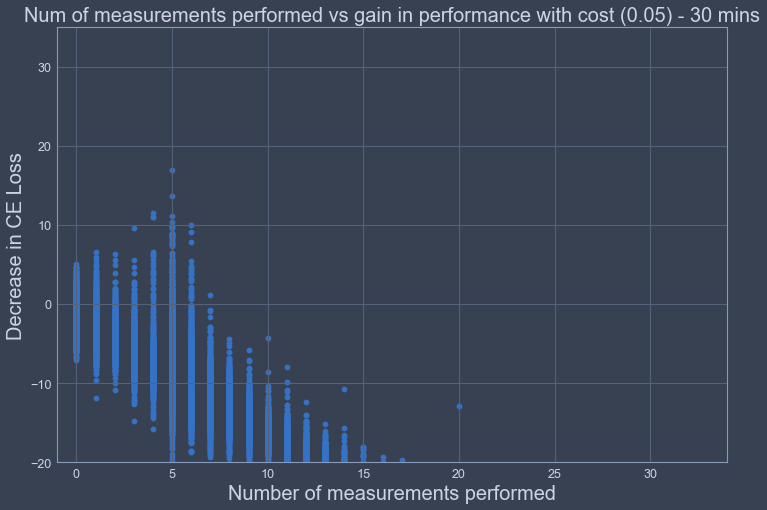

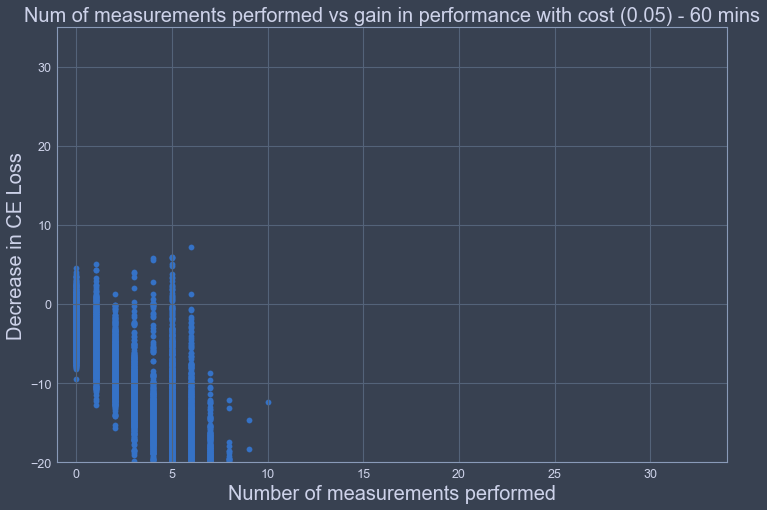

In [58]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.05   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions'],
                   per_action_cost=[k]).tolist() for k in exp}

for k in a:
    plot_scatter_simple(np.sum(a[k][:,:-1], axis=1), r[k],
                        title='Num of measurements performed vs gain in performance with cost ({}) - {} mins'.format(dummy().reward_param_3, k),
                        ylabel='Decrease in CE Loss',
                        xlabel='Number of measurements performed',
                       xlim=(-1, 34),
                       ylim=(-20,35))


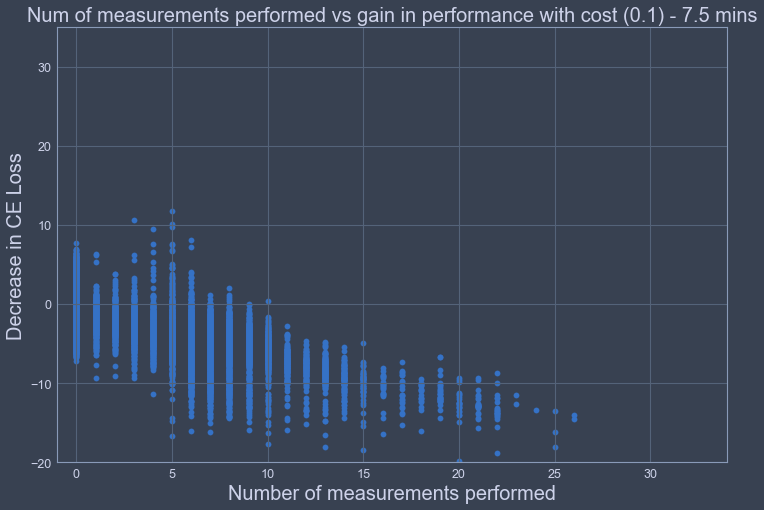

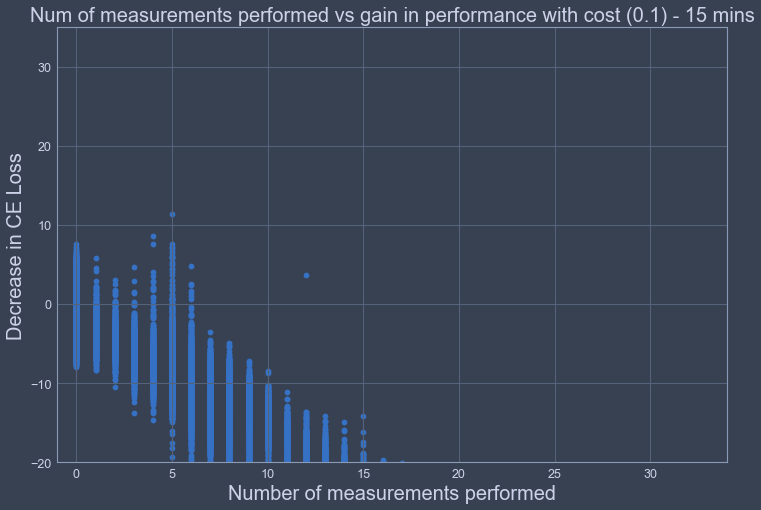

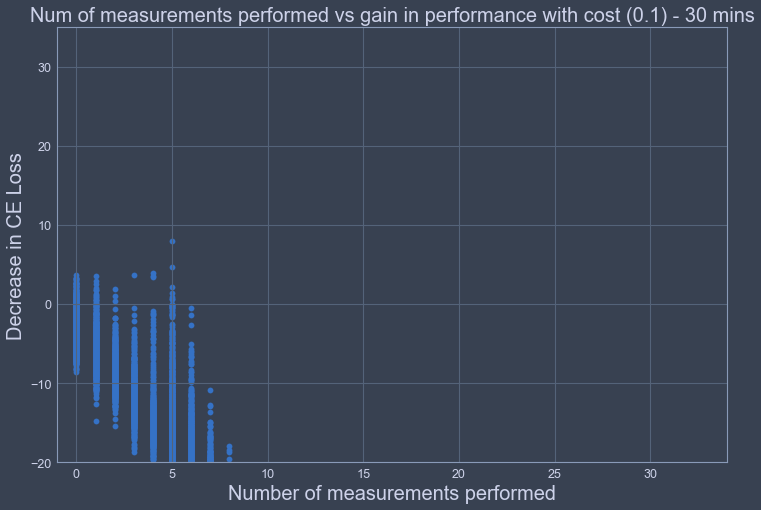

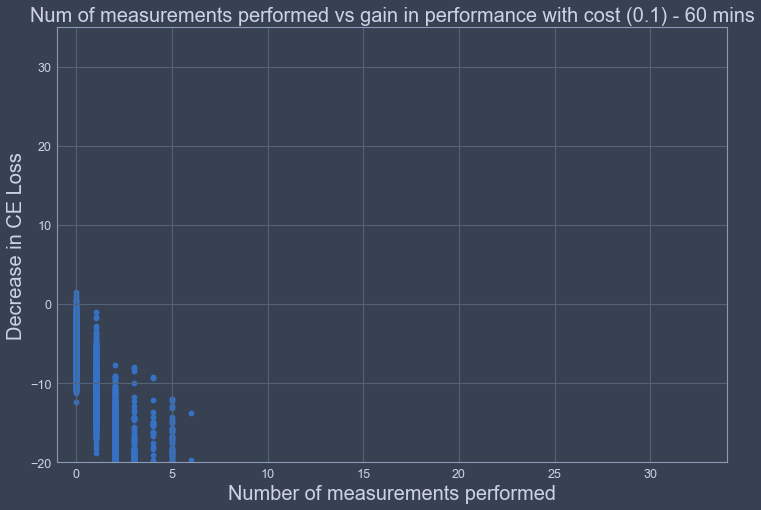

In [61]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.1   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions'],
                   per_action_cost=[k]).tolist() for k in exp}

for k in a:
    plot_scatter_simple(np.sum(a[k][:,:-1], axis=1), r[k],
                        title='Num of measurements performed vs gain in performance with cost ({}) - {} mins'.format(dummy().reward_param_3, k),
                        ylabel='Decrease in CE Loss',
                        xlabel='Number of measurements performed',
                       xlim=(-1, 34),
                       ylim=(-20,35))


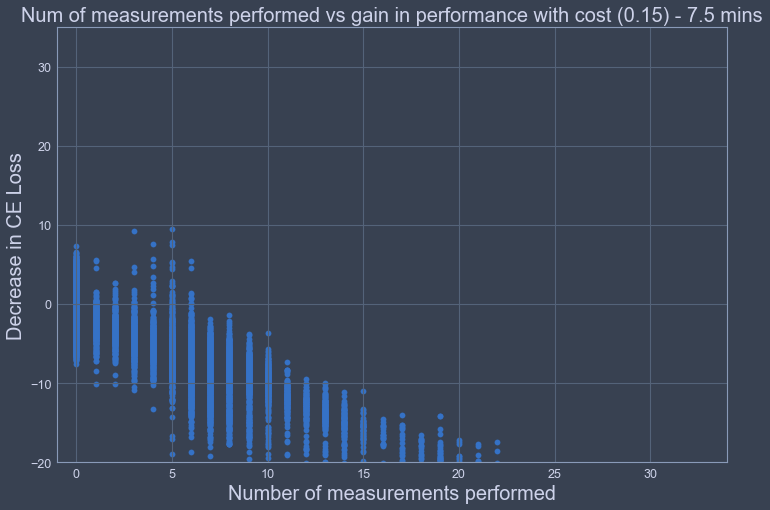

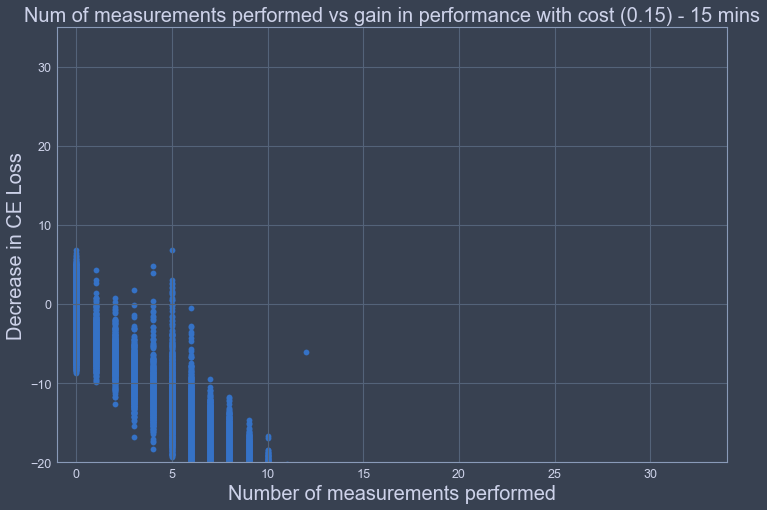

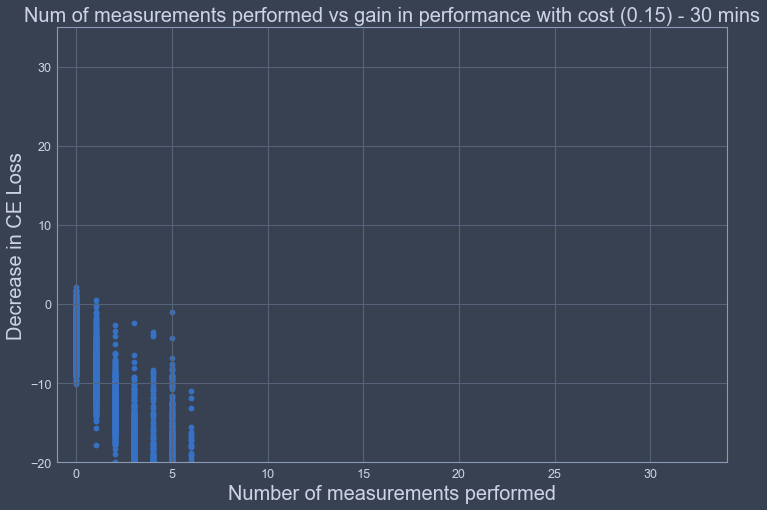

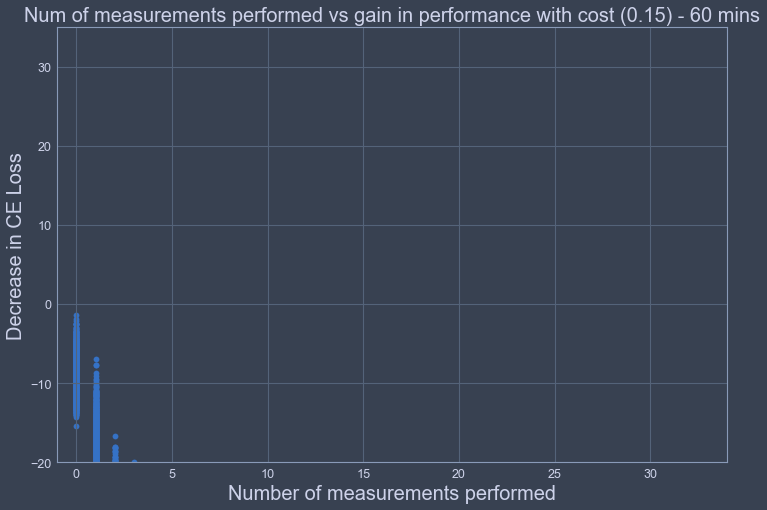

In [62]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.15   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions'],
                   per_action_cost=[k]).tolist() for k in exp}

for k in a:
    plot_scatter_simple(np.sum(a[k][:,:-1], axis=1), r[k],
                        title='Num of measurements performed vs gain in performance with cost ({}) - {} mins'.format(dummy().reward_param_3, k),
                        ylabel='Decrease in CE Loss',
                        xlabel='Number of measurements performed',
                       xlim=(-1, 34),
                       ylim=(-20,35))


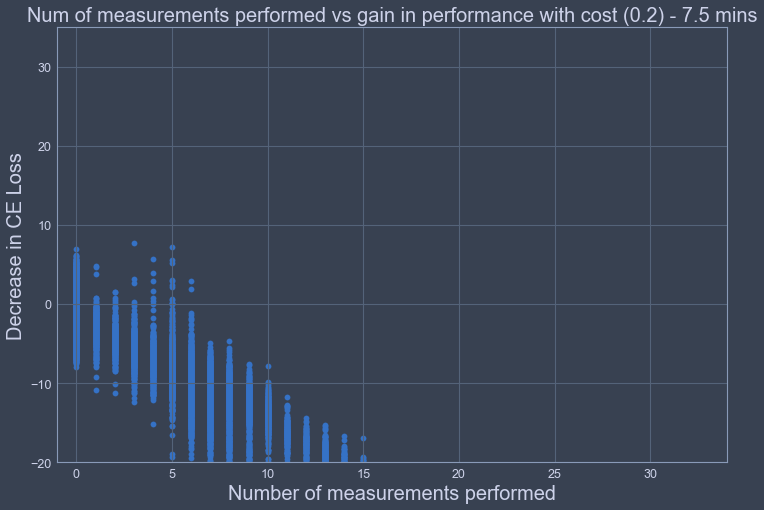

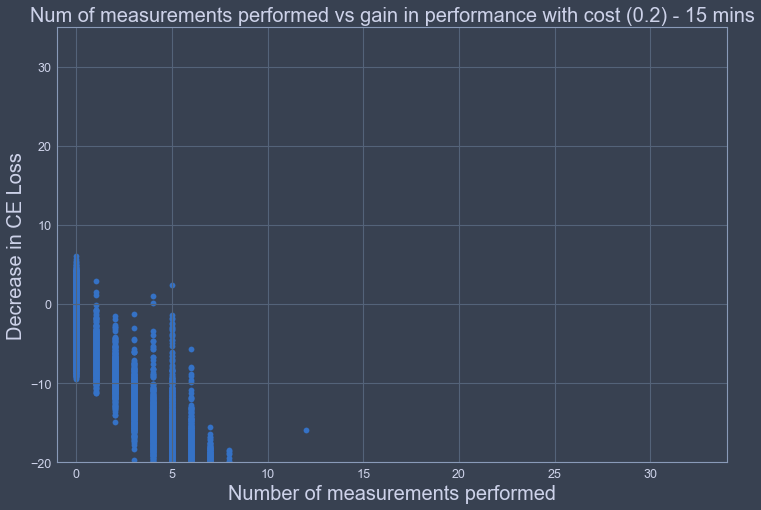

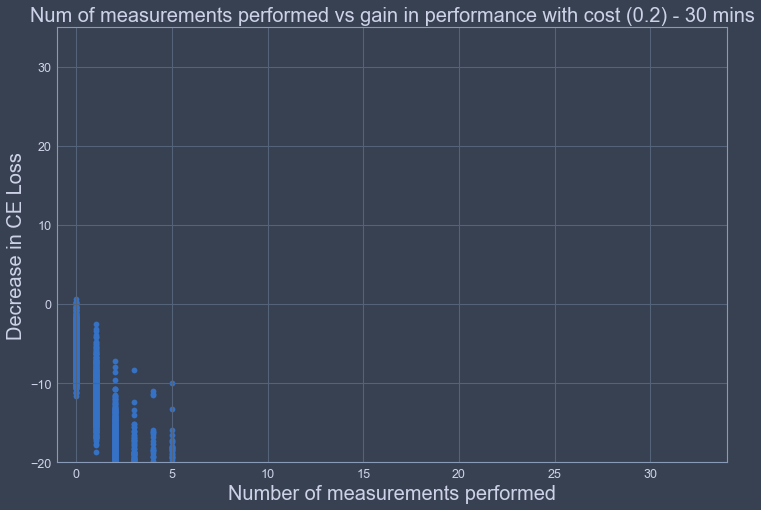

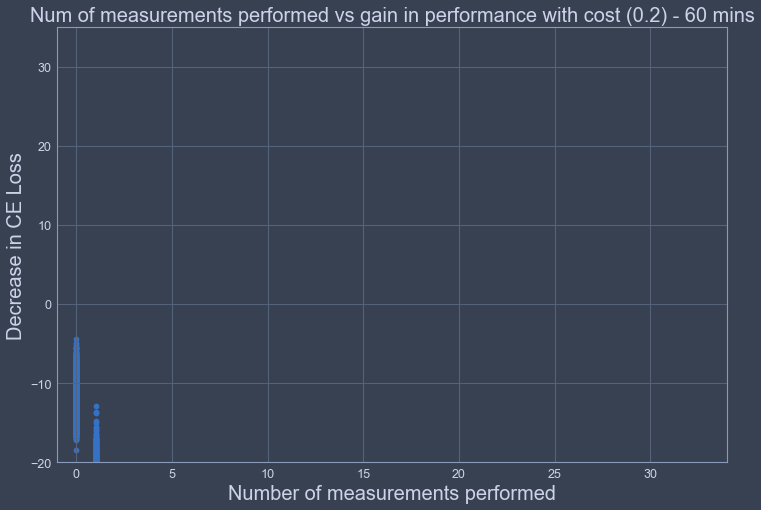

In [63]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.2   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions'],
                   per_action_cost=[k]).tolist() for k in exp}

for k in a:
    plot_scatter_simple(np.sum(a[k][:,:-1], axis=1), r[k],
                        title='Num of measurements performed vs gain in performance with cost ({}) - {} mins'.format(dummy().reward_param_3, k),
                        ylabel='Decrease in CE Loss',
                        xlabel='Number of measurements performed',
                       xlim=(-1, 34),
                       ylim=(-20,35))


# Anslysis distribution of measurements made by physician

In [60]:
measurement_freqs = zip(np.mean(a[7.5], axis = 0), range(35),feature_names)
sorted(measurement_freqs)

[(4e-05, 9, 'Cholesterol'),
 (0.00036, 7, 'Capillary refill rate'),
 (0.00126, 0, 'Albumin'),
 (0.00227, 2, 'Bilirubin'),
 (0.0025, 31, 'Weight'),
 (0.00408, 17, 'Lactate'),
 (0.00513, 26, 'Prothrombin time'),
 (0.00557, 6, 'Calcium ionized'),
 (0.00587, 23, 'Partial thromboplastin time'),
 (0.00607, 32, 'White blood cell count'),
 (0.00663, 5, 'Calcium'),
 (0.0072, 22, 'Partial pressure of oxygen'),
 (0.00746, 3, 'Blood urea nitrogen'),
 (0.00748, 1, 'Bicarbonate'),
 (0.00776, 8, 'Chloride'),
 (0.00831, 16, 'Hemoglobin'),
 (0.00845, 24, 'Platelets'),
 (0.00914, 12, 'Fraction inspired oxygen'),
 (0.00958, 25, 'Potassium'),
 (0.00979, 10, 'Creatinine'),
 (0.00996, 18, 'Magnesium'),
 (0.01099, 21, 'Partial pressure of carbon dioxide'),
 (0.01115, 4, 'CO2'),
 (0.01472, 33, 'pH'),
 (0.02148, 13, 'Glascow coma scale total'),
 (0.0303, 14, 'Glucose'),
 (0.03753, 29, 'Temperature'),
 (0.06694, 30, 'Urine output'),
 (0.12652, 20, 'Oxygen saturation'),
 (0.13314, 19, 'Mean blood pressure'),
 (0

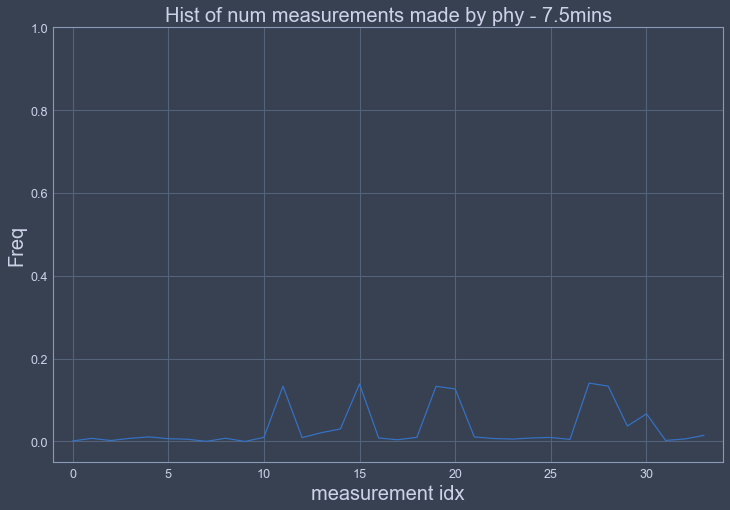

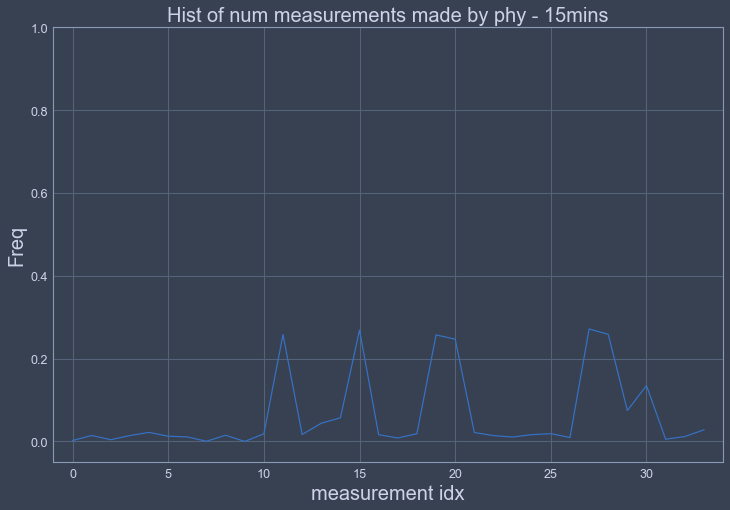

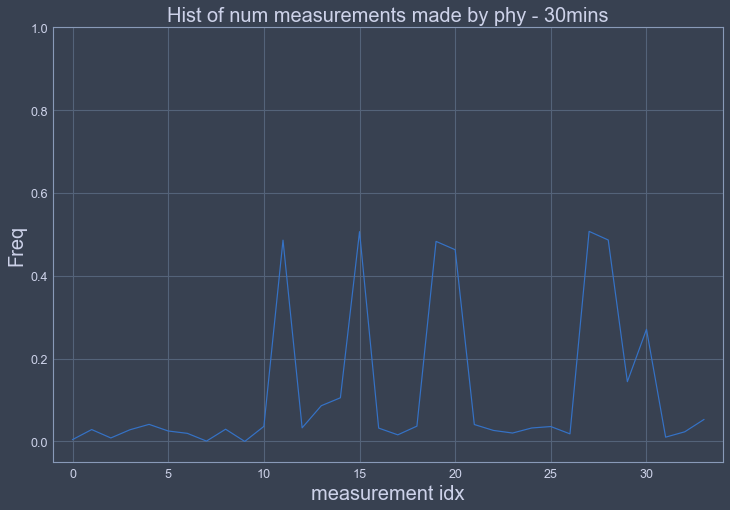

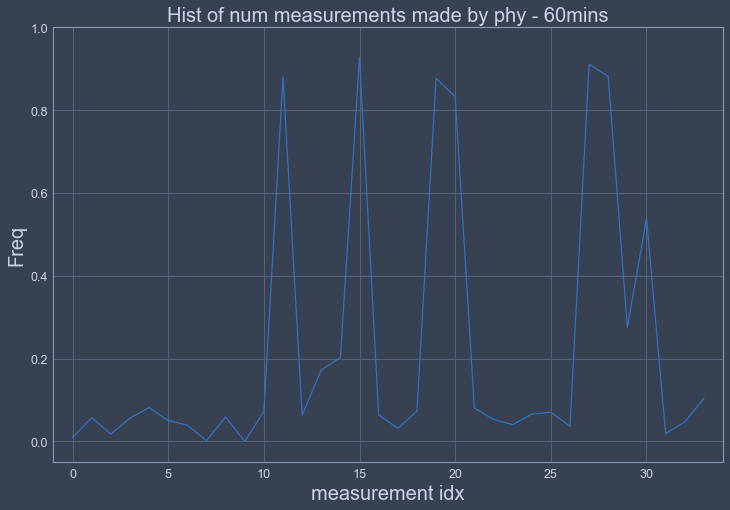

In [23]:
for k in a:
    plot_line(range(34), np.sum(a[k][:,:-1], axis = 0) / a[k].shape[0],
              title='Hist of num measurements made by phy - {}mins'.format(k),
              xlabel='measurement idx',
              ylabel='Freq',
             xlim=(-1,34),
             ylim=(-0.05, 1.0))

# Generate measureme cost that is inversely prop to measurement freq

In [49]:
per_action_cost = {k: 1 - np.mean(a[k], axis = 0) for k in a}

In [51]:
per_action_cost[7.5]

array([0.99873, 0.99248, 0.99773, 0.9925 , 0.9888 , 0.99332, 0.99437,
       0.99964, 0.9922 , 0.99996, 0.99026, 0.86641, 0.99091, 0.97859,
       0.96969, 0.86123, 0.9917 , 0.99592, 0.99009, 0.86684, 0.87342,
       0.98896, 0.99279, 0.99422, 0.99157, 0.99034, 0.99494, 0.85924,
       0.8663 , 0.96256, 0.9331 , 0.99748, 0.99393, 0.98513, 0.     ],
      dtype=float32)

In [52]:
import pickle 

In [53]:
for k in per_action_cost:
    pickle.dump(per_action_cost[k], open(exp_dir[k] + 'per_action_cost.pkl', 'wb'))

# Analyze reward given inversely propotional measurement cost

In [54]:
class dummy:
    def __init__(self):
        self.reward_param_1 = 100.0  # gain in performance
        self.reward_param_2 = 0.0   # reduce in prob std
        self.reward_param_3 = 0.2   # action cost

r = {k: reward_func(args=dummy(),
            cur_probs=exp[k]['cur_probs'],
            next_probs=exp[k]['next_probs'],
            labels=exp[k]['labels'],
            actions=exp[k]['cur_actions']).tolist() for k in exp}


In [55]:
null_action_rewards = {k: [r[k][i] for i in range(len(null_actions_only[k])) if null_actions_only[k][i]] for k in null_actions_only}
real_action_rewards = {k: [r[k][i] for i in range(len(real_actions_only[k])) if real_actions_only[k][i]] for k in real_actions_only}

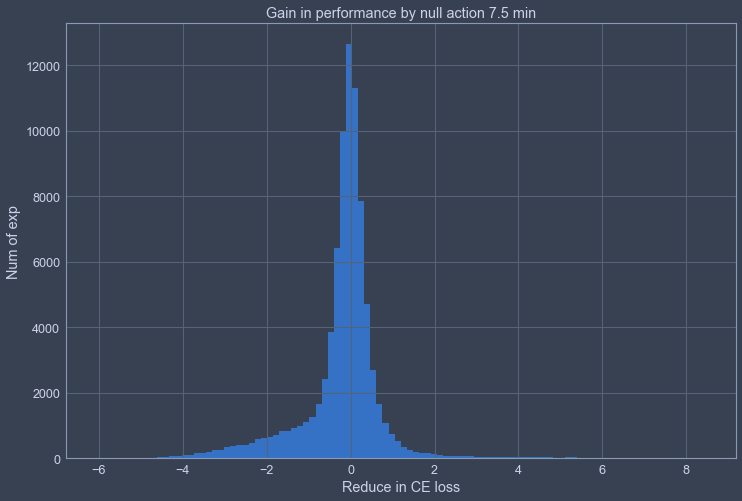

mean: -0.1978247111250867, std 0.9799019590913056


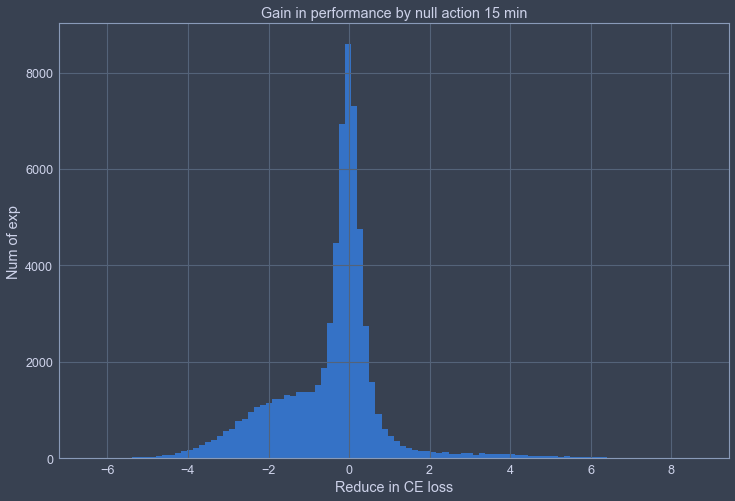

mean: -0.44397809116744885, std 1.3563960343839325


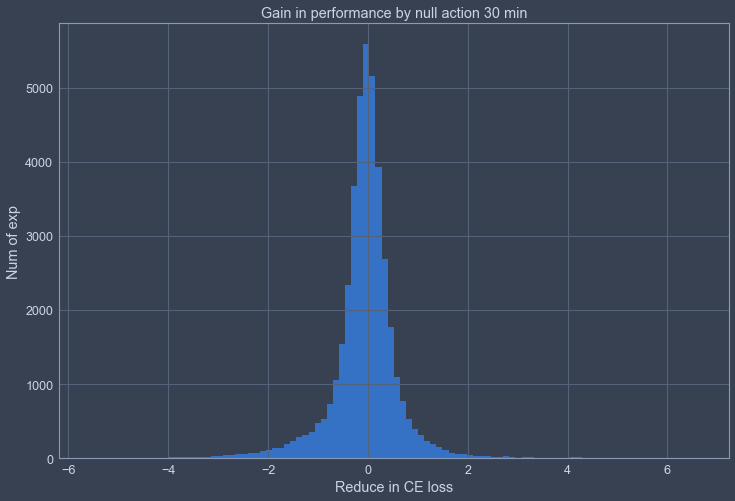

mean: -0.06011639703965714, std 0.6920442043482754


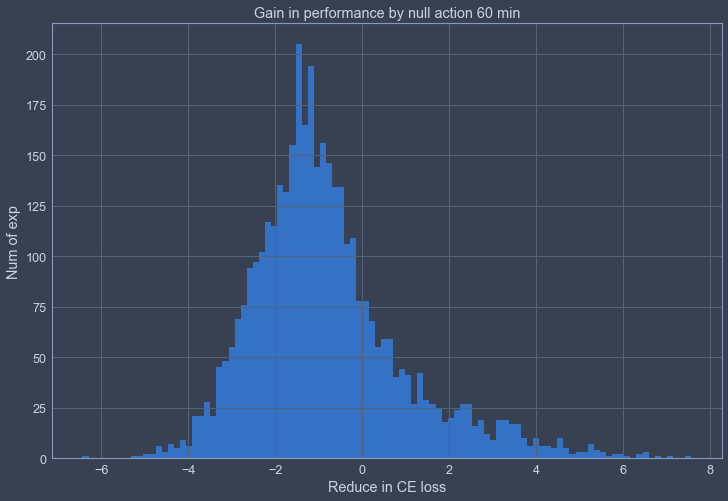

mean: -0.8091608732977201, std 1.765434404812307


In [56]:
for k in null_action_rewards:
    plot_hist_simple(null_action_rewards[k], title='Gain in performance by null action {} min'.format(k),
                     xlabel='Reduce in CE loss', ylabel='Num of exp')
    print('mean: {}, std {}'.format(np.mean(null_action_rewards[k]), np.std(null_action_rewards[k])))

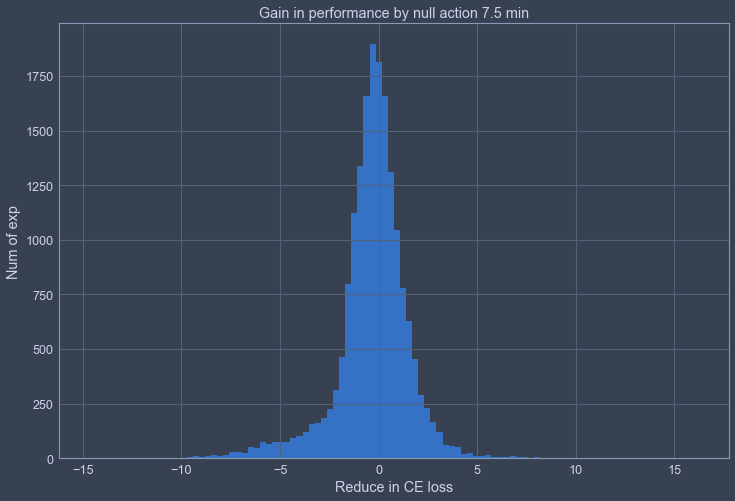

mean: -0.31283552854890195, std 1.8712992063800287


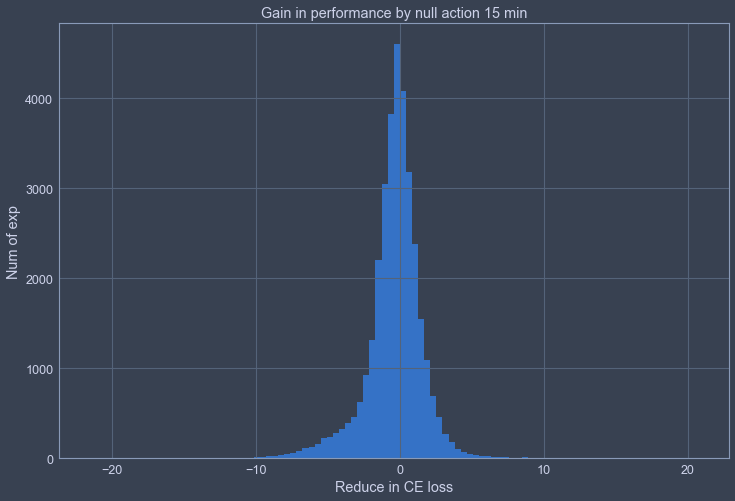

mean: -0.3748189103420693, std 1.9763756509385857


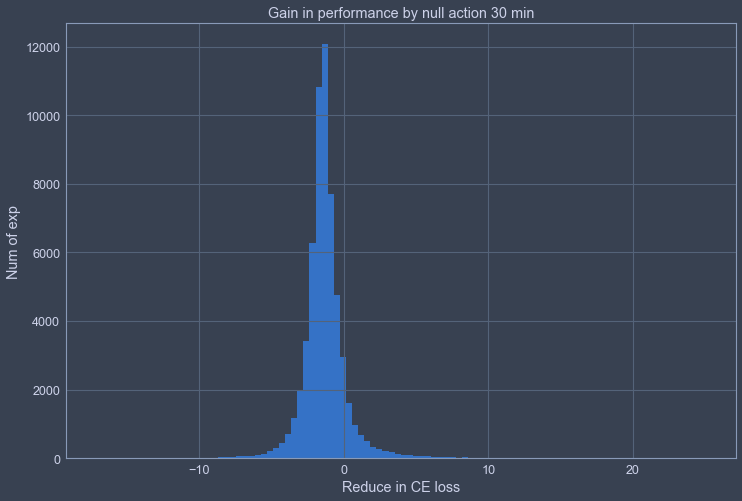

mean: -1.2796430000153298, std 1.6345996930658049


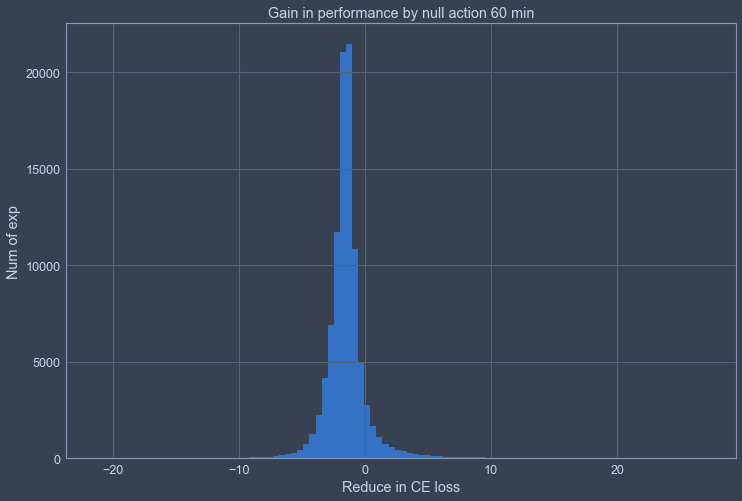

mean: -1.4670080603773823, std 1.7500703208871666


In [57]:
for k in real_action_rewards:
    plot_hist_simple(real_action_rewards[k], title='Gain in performance by null action {} min'.format(k),
                     xlabel='Reduce in CE loss', ylabel='Num of exp')
    print('mean: {}, std {}'.format(np.mean(real_action_rewards[k]), np.std(real_action_rewards[k])))